# Machine Translation + Transformer

In [1]:
# PyTorch Libraries for Deep Learning  
import torch  
import torch.nn as nn  
import torch.nn.functional as F  

# TorchText for NLP Preprocessing  
import torchtext  
torchtext.disable_torchtext_deprecation_warning()  
from torchtext.data.utils import get_tokenizer  

# Standard Libraries for Data Handling and Computation  
import random  
import math  
import time  
import os  
import gc  
import re  

# Visualization Libraries  
import matplotlib.pyplot as plt  
import matplotlib.ticker as ticker  

# Data Manipulation Libraries  
import numpy as np  
import pandas as pd  

# NLP Libraries for Tokenization and Processing  
import datasets  
import spacy  
import nltk  
import stanza  

# Mixed Precision Training for Efficient Computation  
from torch.cuda.amp import GradScaler, autocast  

# Ensure reproducibility by setting a random seed  
SEED = 1234  
torch.manual_seed(SEED)  
torch.backends.cudnn.deterministic = True  

In [2]:
# Set device to GPU if available, otherwise use CPU  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(device)  

cuda


In [3]:
torch.__version__

'2.3.0+cu121'

## 1. ETL: Loading the English-Sindhi dataset


In [4]:
# Download Sindhi model
stanza.download('sd')

2025-02-02 22:32:56 INFO: Downloaded file to C:\Users\Mir Ali\stanza_resources\resources.json
2025-02-02 22:32:56 INFO: Downloading default packages for language: sd (Sindhi) ...
2025-02-02 22:32:57 INFO: File exists: C:\Users\Mir Ali\stanza_resources\sd\default.zip
2025-02-02 22:33:01 INFO: Finished downloading models and saved to C:\Users\Mir Ali\stanza_resources


In [5]:
# Load the Sindhi pipeline with tokenizer
nlp = stanza.Pipeline(lang='sd', processors='tokenize')

2025-02-02 22:33:01 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-02-02 22:33:01 INFO: Downloaded file to C:\Users\Mir Ali\stanza_resources\resources.json
2025-02-02 22:33:01 INFO: Loading these models for language: sd (Sindhi):
| Processor | Package |
-----------------------
| tokenize  | isra    |

2025-02-02 22:33:01 INFO: Using device: cuda
2025-02-02 22:33:01 INFO: Loading: tokenize
2025-02-02 22:33:04 INFO: Done loading processors!


In [6]:
def stanza_sindhi_tokenizer(text):
    """Tokenizes Sindhi text using Stanza."""
    doc = nlp(text)  # Process text using Stanza
    tokens = [word.text for sentence in doc.sentences for word in sentence.words]  # Extract tokens
    return tokens

# Example usage
text1 = "زندگي هڪ سفر آهي"
tokens1 = stanza_sindhi_tokenizer(text1)

text2 = "آئون اسڪول وڃان ٿو."
tokens2 = stanza_sindhi_tokenizer(text2)

print(tokens1)
print(tokens2)

['زندگي', 'هڪ', 'سفر', 'آهي']
['آئون', 'اسڪول', 'وڃان', 'ٿو', '.']


**Filtering Parallel Corpus Based on Alignment Scores**

This script processes a bilingual corpus (English-Sindhi) by filtering sentence pairs based on alignment scores.  

### Steps:
1. **Load Alignment Scores:**  
   - Reads alignment scores from the file `NLLB.en-sd.scores`.  
   - Converts each score to a floating-point number.  

2. **Filter Sentence Pairs:**  
   - Uses a threshold (`0.5`) to retain only well-aligned sentence pairs.  
   - Sentence pairs with scores greater than `0.5` are kept.  

3. **Display Corpus Sizes:**  
   - Prints the number of sentence pairs before and after filtering.  

This helps improve translation quality by removing weakly aligned pairs.


**NLLB.en-sd.en Dataset**

The **NLLB.en-sd.en** dataset is part of the **No Language Left Behind (NLLB)** project and consists of parallel sentence pairs in **English** and **Sindhi**. This dataset is designed to aid in training and evaluating machine translation models, particularly for low-resource languages. The NLLB project aims to provide scalable and human-centered translation solutions.

### Dataset Source:
The dataset can be downloaded from the [OPUS website](https://opus.nlpl.eu/NLLB/corpus/version/NLLB).

### Citation:
Tiedemann, J. (2022). OPUS: A large parallel corpus for research and development. In *Proceedings of the 13th International Conference on Language Resources and Evaluation (LREC 2022)*.

This dataset enables the development of translation models for underrepresented languages, contributing to cross-lingual communication.


In [7]:
# Load the English and Sindhi sentences
with open("corpus/NLLB.en-sd.en", "r", encoding="utf-8") as f:
    english_sentences = f.readlines()

with open("corpus/NLLB.en-sd.sd", "r", encoding="utf-8") as f:
    sindhi_sentences = f.readlines()

# Ensure both files have the same number of sentences
assert len(english_sentences) == len(sindhi_sentences), "Mismatch in the number of sentences"

# Create a list of sentence pairs
parallel_corpus = list(zip(english_sentences, sindhi_sentences))

# Example: Print the last 3 sentence pairs
for en, sd in parallel_corpus[-3:]:
    print(f"English: {en.strip()}")
    print(f"Sindhi: {sd.strip()}")
    print()

English: your safety or for the function of the appliance.
Sindhi: هن جي پنهنجي فنڪشن لاءِ ، يا هڪ مناسب فنڪشن لاءِ.

English: ‡Coded as 1 (female) or 2 (male).
Sindhi: طرح 1 (الماس), طرح 2 (طلا)

English: ドキドキ: day after day &
Sindhi: سانچو:عمر سالن ۽ ڏينهن ۾/ڏينهن/دستاويز



In [8]:
# Load the alignment scores
with open("corpus/NLLB.en-sd.scores", "r", encoding="utf-8") as f:
    scores = [float(line.strip()) for line in f]

# Filter the dataset based on a threshold (e.g., keep pairs with score > 0.5)
threshold = 0.5
filtered_corpus = [(en, sd) for en, sd, score in zip(english_sentences, sindhi_sentences, scores) if score > threshold]

print(f"Original corpus size: {len(parallel_corpus)}")
print(f"Filtered corpus size: {len(filtered_corpus)}")

Original corpus size: 8924699
Filtered corpus size: 8924699


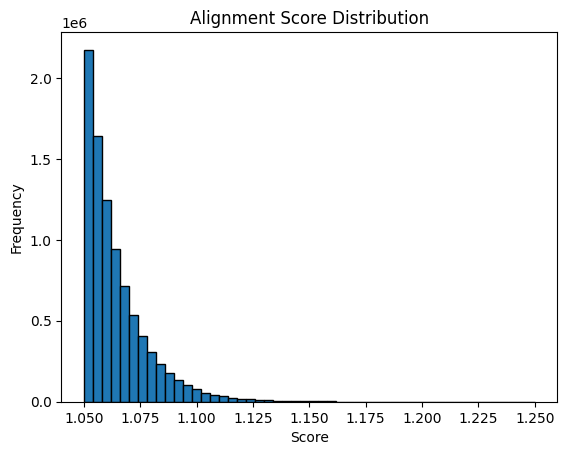

In [9]:
import matplotlib.pyplot as plt

# Plot a histogram of the scores
plt.hist(scores, bins=50, edgecolor='black')
plt.title("Alignment Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

In [10]:
print("Minimum score:", min(scores))
print("Maximum score:", max(scores))

Minimum score: 1.05
Maximum score: 1.2499706


**Filtering Corpus Using the 95th Percentile Threshold**

This script filters a bilingual corpus (English-Sindhi) by keeping only the top 5% of sentence pairs with the highest alignment scores.  

### Steps:  
1. **Calculate Dynamic Threshold:**  
   - Computes the 95th percentile of alignment scores using NumPy.  
   - Ensures only the best-aligned sentence pairs are retained.  

2. **Filter Sentence Pairs:**  
   - Keeps sentence pairs where the alignment score is above the 95th percentile.  

3. **Display Results:**  
   - Prints the threshold value and the size of the filtered corpus.  

In [11]:
# Calculate the 95th percentile score to set a dynamic threshold  
threshold = np.percentile(scores, 95)  
print("95th percentile threshold:", threshold)  

# Filter the dataset to keep only the top 5% of sentence pairs based on alignment scores  
filtered_corpus = [(en, sd) for en, sd, score in zip(english_sentences, sindhi_sentences, scores) if score > threshold]  

# Print the number of sentence pairs remaining after filtering  
print(f"Filtered corpus size: {len(filtered_corpus)}")  

97th percentile threshold: 1.0929
Filtered corpus size: 446234


In [12]:
# Save the filtered corpus to new files
with open("filtered_en.txt", "w", encoding="utf-8") as f_en, open("filtered_sd.txt", "w", encoding="utf-8") as f_sd:
    for en, sd in filtered_corpus:
        f_en.write(en)
        f_sd.write(sd)

In [13]:
# Load language models
nlp_en = spacy.load("en_core_web_sm")  # English

# Tokenize a sentence
english_sentence = "This is a test."
sindhi_sentence = "هي هڪ ٽيسٽ آهي."

# Tokenize English using SpaCy
doc_en = nlp_en(english_sentence)
tokenized_en = [token.text for token in doc_en]

# Tokenize Sindhi using Stanza
tokenized_sd =stanza_sindhi_tokenizer(sindhi_sentence)

print("Tokenized English:", tokenized_en)
print("Tokenized Sindhi:", tokenized_sd)

Tokenized English: ['This', 'is', 'a', 'test', '.']
Tokenized Sindhi: ['هي', 'هڪ', 'ٽيسٽ', 'آهي', '.']


In [14]:
# Sort the corpus by scores
sorted_corpus = sorted(zip(english_sentences, sindhi_sentences, scores), key=lambda x: x[2], reverse=True)

# Print top 5 high-quality pairs
print("Top 5 high-quality pairs:")
for en, sd, score in sorted_corpus[:5]:
    print(f"Score: {score}")
    print(f"English: {en.strip()}")
    print(f"Sindhi: {sd.strip()}")
    print()

# Print bottom 5 low-quality pairs
print("Bottom 5 low-quality pairs:")
for en, sd, score in sorted_corpus[-5:]:
    print(f"Score: {score}")
    print(f"English: {en.strip()}")
    print(f"Sindhi: {sd.strip()}")
    print()

Top 5 high-quality pairs:
Score: 1.2499706
English: "Enter you therein in peace, this is the day of Eternal Life (or Immortality)."
Sindhi: داخل ٿيو ان ۾ سلام سان اهو هميشہ رهڻ جو ڏينهن آهي .

Score: 1.2495571
English: By your Lord, We will ask them all.
Sindhi: 15:92 - 92. (تھڙي طرح) تنھنجي پالڻھار جو قسم آھي ته انھن مڙني کان ضرور پڇنداسون.

Score: 1.2493936
English: The pharaoh went on to say, "You must have a blueprint for anything that you wish to build.
Sindhi: تون وري فائلون ته اوھان کي بحال ۽ ڪلڪ ڪريو "حاصل" کين پنهنجي ڳوڙهي کي بچائڻ لاء وارا آھن چونڊيو ڪري سگهو ٿا.

Score: 1.2487581
English: Have you considered: if We let them enjoy themselves for some years.
Sindhi: ڇا پوءِ ڏٺو تو جيڪڏهن نفعو ڏنو اسان انهن کي ڪي سال .

Score: 1.2485536
English: This Book has no doubt in it - a guidance for the God-fearing,
Sindhi: هي اهو ڪتاب آهي جنهن ۾ ڪا به شڪ جي جاءِ ناهي، انهيءَ ۾ هدايت آهي پرهيزگارن لاءِ (علامه عبدالوحيد جان سرهندي)

Bottom 5 low-quality pairs:
Score: 1.05
English: young 

## 2. EDA - simple investigation

In [15]:
from datasets import Dataset

# Convert the filtered corpus into a Hugging Face Dataset
dataset = Dataset.from_dict({
    "translation": [
        {"en": en.strip(), "sd": sd.strip()} for en, sd in filtered_corpus
    ]
})
print(dataset)

Dataset({
    features: ['translation'],
    num_rows: 446234
})


In [16]:
from datasets import Dataset, DatasetDict

# Convert the filtered corpus into a Hugging Face Dataset
dataset = Dataset.from_dict({
    "translation": [
        {"en": en.strip(), "sd": sd.strip()} for en, sd in filtered_corpus
    ]
})
# Split the dataset into train, validation, and test sets
train_test_split = dataset.train_test_split(test_size=0.05)  # 5% for the test set

# Further split the test set into validation and test sets (e.g., 50% each)
validation_test_split = train_test_split['test'].train_test_split(test_size=0.5)

# Combine all splits into a DatasetDict
dataset = DatasetDict({
    "train": train_test_split['train'],
    "validation": validation_test_split['train'],
    "test": validation_test_split['test']
})
# Print the resulting DatasetDict
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 423922
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 11156
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 11156
    })
})


In [17]:
# Importing necessary module
from numpy.random import default_rng

# Initializing a random number generator with a specified seed
rng = default_rng(seed=SEED)

# Selecting a random sample of indices from the training dataset

selected_size = 200_000
select_index = rng.choice(len(dataset['train']), size= selected_size, replace=False)

# Filtering the training dataset based on the selected indices
# This ensures that only the randomly selected subset of data is retained
dataset['train'] = dataset['train'].filter(lambda data, index: index in select_index, with_indices=True)

Filter:   0%|          | 0/423922 [00:00<?, ? examples/s]

In [18]:
val_test_size = 10_000 
select_index_val = rng.choice(len(dataset['validation']), size=val_test_size, replace=False)
select_index_test = rng.choice(len(dataset['test']), size=val_test_size, replace=False)

dataset['validation'] = dataset['validation'].filter(lambda data, index: index in select_index_val, with_indices=True)
dataset['test'] = dataset['test'].filter(lambda data, index: index in select_index_test, with_indices=True)

Filter:   0%|          | 0/11156 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11156 [00:00<?, ? examples/s]

In [19]:
# Define a lambda function to extract the translation column for a specific language
get_new_col = lambda data, lang: {lang: data['translation'][lang]}

# Map the lambda function to create a new column for Sindhi translation
dataset = dataset.map(get_new_col, fn_kwargs={'lang': "sd"})

# Map the lambda function to create a new column for English translation and remove the original translation column
dataset = dataset.map(get_new_col, remove_columns=['translation'], fn_kwargs={'lang': "en"})

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [20]:
#let's take a look at one example of train
sample = next(iter(dataset['train']))
sample

{'sd': 'ڪم يا راند لاءِ وڏو آهي.', 'en': 'Great for work or play.'}

In [21]:
train_size = len(list(iter(dataset['train'])))
train_size

200000

## 3. Preprocessing

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line:
```
python3 -m spacy download en_core_web_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [22]:
# Place-holders
token_transform = {}
vocab_transform = {}

SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'sd'

## Importing of tokenizer libraries 
token_transform["en"] = get_tokenizer('spacy', language='en_core_web_sm')

token_transform["sd"] = stanza_sindhi_tokenizer  

In [23]:
# Debug: Print tokenized sentences BEFORE processing the dataset
print("Original English sentence:", dataset['train'][0][SRC_LANGUAGE])
print("Tokenized English:", token_transform["en"](dataset['train'][0][SRC_LANGUAGE]))

print("Original Sindhi sentence:", dataset['train'][0][TRG_LANGUAGE])
print("Tokenized Sindhi:", token_transform["sd"](dataset['train'][0][TRG_LANGUAGE]))


Original English sentence: Great for work or play.
Tokenized English: ['Great', 'for', 'work', 'or', 'play', '.']
Original Sindhi sentence: ڪم يا راند لاءِ وڏو آهي.
Tokenized Sindhi: ['ڪم', 'يا', 'راند', 'لاءِ', 'وڏو', 'آهي', '.']


In [24]:
# Example sentence from the dataset
sindhi_example = dataset['train']['sd'][123]

# Example of tokenization for Urdu part
print("Sentence (Sindhi): ", sindhi_example)
print("Tokenization (Sindhi): ", token_transform['sd'](sindhi_example))  

# Example of tokenization for English part
sentence_english = dataset['train']['en'][123]
print("Sentence (English): ", sentence_english)
print("Tokenization (English): ", token_transform['en'](sentence_english)) 

Sentence (Sindhi):  مون کي افسوس آهي ته مان اياز سان آخر ۾ ملي نه سگهيس.
Tokenization (Sindhi):  ['مون', 'کي', 'افسوس', 'آهي', 'ته', 'مان', 'اياز', 'سان', 'آخر', '۾', 'ملي', 'نه', 'سگهيس', '.']
Sentence (English):  I'm sorry that I couldn't make it in the end.
Tokenization (English):  ['I', "'m", 'sorry', 'that', 'I', 'could', "n't", 'make', 'it', 'in', 'the', 'end', '.']


In [25]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

In [26]:
def tokenize_the_data(example, lang):
    return {lang: token_transform[lang](example[lang])}  # Tokenize using the correct language tokenizer

In [27]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

In [28]:
# Tokenize the source language and remove the original column
tokenized_dataset = dataset.map(tokenize_the_data, remove_columns=[SRC_LANGUAGE], fn_kwargs={'lang': SRC_LANGUAGE})

# Tokenize the target language and remove the original column
tokenized_dataset = tokenized_dataset.map(tokenize_the_data, remove_columns=[TRG_LANGUAGE], fn_kwargs={'lang': TRG_LANGUAGE})

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [29]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sd', 'en'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['sd', 'en'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sd', 'en'],
        num_rows: 10000
    })
})

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [30]:
print(tokenized_dataset['train'][0])

{'sd': ['ڪم', 'يا', 'راند', 'لاءِ', 'وڏو', 'آهي', '.'], 'en': ['Great', 'for', 'work', 'or', 'play', '.']}


In [31]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [32]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(tokenized_dataset['train'][ln],
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end
# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [33]:
torch.save(vocab_transform, 'vocab.pth')

# Verify immediately after saving
loaded_vocab_check = torch.load('vocab.pth')

print("🔹 After Saving & Reloading:")
print("English vocab size:", len(loaded_vocab_check['en']))
print("Sindhi vocab size:", len(loaded_vocab_check['sd']))

assert len(loaded_vocab_check['en']) == len(vocab_transform['en']), "Mismatch after saving!"
assert len(loaded_vocab_check['sd']) == len(vocab_transform['sd']), "Mismatch after saving!"
print("✅ Vocabulary is correctly saved and reloaded!")

🔹 After Saving & Reloading:
English vocab size: 28900
Sindhi vocab size: 44656
✅ Vocabulary is correctly saved and reloaded!


### Checking vocab

In [34]:
print("Vocabulary keys (languages):", vocab_transform.keys())  # Should be ['en', 'sd'] or similar

Vocabulary keys (languages): dict_keys(['en', 'sd'])


In [35]:
print("English Vocabulary Size:", len(vocab_transform['en']))
print("Sindhi Vocabulary Size:", len(vocab_transform['sd']))


English Vocabulary Size: 28900
Sindhi Vocabulary Size: 44656


In [36]:
special_tokens = ["<sos>", "<eos>", "<unk>", "<pad>"]
for token in special_tokens:
    print(f"'{token}' in English vocab:", token in vocab_transform['en'].get_stoi())
    print(f"'{token}' in Sindhi vocab:", token in vocab_transform['sd'].get_stoi())

'<sos>' in English vocab: True
'<sos>' in Sindhi vocab: True
'<eos>' in English vocab: True
'<eos>' in Sindhi vocab: True
'<unk>' in English vocab: True
'<unk>' in Sindhi vocab: True
'<pad>' in English vocab: True
'<pad>' in Sindhi vocab: True


In [37]:
print(vocab_transform.keys())  # Should print dict_keys(['en', 'sd'])

dict_keys(['en', 'sd'])


In [38]:
src_vocab = vocab_transform['en']  # Get English vocabulary
trg_vocab = vocab_transform['sd']  # Get Sindhi vocabulary

In [39]:
#see some example
vocab_transform[SRC_LANGUAGE](['me', 'also'])

[42, 115]

In [40]:
print(vocab_transform[TRG_LANGUAGE]['آئون'])
print(vocab_transform[TRG_LANGUAGE]['پڻ'])

107
176


In [41]:
#we can reverse it....
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

#print 111, for example
mapping[123]

'اھو'

In [42]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 111, for example
mapping[123]

'some'

In [43]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [44]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [45]:
#check unique vocabularies
len(mapping)

28900

In [46]:
special_tokens = ["<sos>", "<eos>", "<unk>", "<pad>"]
for token in special_tokens:
    print(f"'{token}' in English vocab:", token in vocab_transform['en'].get_stoi())
    print(f"'{token}' in Sindhi vocab:", token in vocab_transform['sd'].get_stoi())

'<sos>' in English vocab: True
'<sos>' in Sindhi vocab: True
'<eos>' in English vocab: True
'<eos>' in Sindhi vocab: True
'<unk>' in English vocab: True
'<unk>' in Sindhi vocab: True
'<pad>' in English vocab: True
'<pad>' in Sindhi vocab: True


In [47]:
test_words = ["hello", "world", "translation", "language"]
for word in test_words:
    if word in vocab_transform['en'].get_stoi():
        print(f"'{word}' token ID:", vocab_transform['en'][word])
    else:
        print(f"'{word}' not found in English vocab!")

# Check reverse mapping
test_token_id = 100  # Adjust based on vocab size
if test_token_id < len(vocab_transform['sd']):
    print(f"Word for token ID {test_token_id} in Sindhi:", vocab_transform['sd'].get_itos()[test_token_id])
else:
    print(f"Token ID {test_token_id} not found in Sindhi vocab.")

'hello' token ID: 4055
'world' token ID: 102
'translation' token ID: 2372
'language' token ID: 440
Word for token ID 100 in Sindhi: وڃي


In [48]:
test_sentence = "Hello, how are you today?".lower().split()  # Example English sentence
oov_words = [word for word in test_sentence if word not in vocab_transform['en'].get_stoi()]
print("OOV words in test sentence:", oov_words)

OOV words in test sentence: ['hello,', 'today?']


In [49]:
print("Top 20 English words:", list(vocab_transform['en'].get_stoi().keys())[:20])
print("Top 20 Sindhi words:", list(vocab_transform['sd'].get_stoi().keys())[:20])

Top 20 English words: ['shoulda', 'Some', '6:00', 'perniciously', 'fruit', 'wires', 'point', 'excepted', 'blends', 'confidence', 'blog', 'dominant', 'thunder', 'advice', '.', 'restore', 'newspapers', '<unk>', 'Worship', 'NHRA']
Top 20 Sindhi words: ['برات', 'ڏهاڙي', 'ڌاڙيل', 'دعويدارن', 'اتوار', 'ڪڍيائينس', 'به', 'dumping', 'دهڪو', 'لقاءُ', 'هاجس', 'وارن', 'ملنداسـين', 'يسوع', 'انٽري', 'رڪجي', 'سگهيس', 'صلوات', 'بدلائي', 'وڌندو']


In [50]:
print("Tokenized 'hello world' in English:", [vocab_transform['en'][w] for w in "hello world".split()])
print("Tokenized 'هيلو دنيا' in Sindhi:", [vocab_transform['sd'][w] for w in "هيلو دنيا".split()])

Tokenized 'hello world' in English: [4055, 102]
Tokenized 'هيلو دنيا' in Sindhi: [2423, 88]


In [51]:
en_sentence = "hello how are you"
sd_sentence = "هيلو ڪيئن آهيو"

print("English tokens:", [vocab_transform['en'][w] for w in en_sentence.split()])
print("Sindhi tokens:", [vocab_transform['sd'][w] for w in sd_sentence.split()])


English tokens: [4055, 122, 19, 15]
Sindhi tokens: [2423, 111, 184]


## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [52]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

**Create train, val, and test dataloaders**

In [53]:
# Set the batch size for data loaders
batch_size = 64

train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(dataset['validation'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(dataset['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [54]:
## Dividing test loader into its language counterparts
for en, _, sd in train_loader:
    break

In [55]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Sindhi shape: ", sd.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 3])
Sindhi shape:  torch.Size([64, 3])


In [56]:
for i in range(5):  # Print first 5 samples
    print("English sentence:", dataset['train'][i][SRC_LANGUAGE])
    print("Tokenized English:", token_transform["en"](dataset['train'][i][SRC_LANGUAGE]))

    print("Sindhi sentence:", dataset['train'][i][TRG_LANGUAGE])
    print("Tokenized Sindhi:", token_transform["sd"](dataset['train'][i][TRG_LANGUAGE]))
    print("-" * 50)

English sentence: Great for work or play.
Tokenized English: ['Great', 'for', 'work', 'or', 'play', '.']
Sindhi sentence: ڪم يا راند لاءِ وڏو آهي.
Tokenized Sindhi: ['ڪم', 'يا', 'راند', 'لاءِ', 'وڏو', 'آهي', '.']
--------------------------------------------------
English sentence: I Love you you hate me
Tokenized English: ['I', 'Love', 'you', 'you', 'hate', 'me']
Sindhi sentence: I hate you مونکي توهان سان نفرت آهي
Tokenized Sindhi: ['I', 'hate', 'you', 'مونکي', 'توهان', 'سان', 'نفرت', 'آهي']
--------------------------------------------------
English sentence: She is fucked...
Tokenized English: ['She', 'is', 'fucked', '...']
Sindhi sentence: هوءِ هوءِ. . . . لعنت لعنت.
Tokenized Sindhi: ['هوءِ', 'هوءِ', '.', '.', '.', '.', 'لعنت', 'لعنت', '.']
--------------------------------------------------
English sentence: There are numerous photos and
Tokenized English: ['There', 'are', 'numerous', 'photos', 'and']
Sindhi sentence: اهڙا ڪيترائي تصويرون آهن ۽
Tokenized Sindhi: ['اهڙا', 'ڪيترائي',

## 5. Design the model


### Encoder Layer

In [57]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attn_variant, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

### Encoder

In [58]:
## Added attention variant to see which variant we need to work with
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, attn_variant, device, max_length = 500):
        super().__init__()
        self.device = device
        ## Attention variant
        self.attn_variant = attn_variant
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, attn_variant, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src

### Mutli Head Attention Layer



$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$

In [59]:
class AdditiveAttention(nn.Module):
    def __init__(self, head_dim):
        super(AdditiveAttention, self).__init__()
        
        # Linear layers for additive attention
        self.Wa = nn.Linear(head_dim, head_dim)
        self.Ua = nn.Linear(head_dim, head_dim)
        self.V = nn.Linear(head_dim, 1)

    def forward(self, query, keys):
        # Add singleton dimensions for broadcasting
        query = query.unsqueeze(3)
        keys = keys.unsqueeze(2)

        # Apply additive attention mechanism
        features = torch.tanh(self.Wa(query) + self.Ua(keys))
        
        # Calculate attention scores
        scores = self.V(features).squeeze(-1)
        
        return scores

In [60]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, attn_variant, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        
        # Initialize parameters
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.attn_variant = attn_variant

        # Linear transformations for query, key, value, and output
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Scale factor for attention scores
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        # Initialize additive attention mechanism
        self.additive_attention = AdditiveAttention(self.head_dim)

    def forward(self, query, key, value, mask=None):
        # Shapes: query = [batch size, query len, hid dim], key = [batch size, key len, hid dim], value = [batch size, value len, hid dim]

        batch_size = query.shape[0]

        # Apply linear transformations to query, key, and value
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Reshape and permute for multi-head attention
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Calculate attention scores based on the selected attention variant
        if self.attn_variant == "multiplicative":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        elif self.attn_variant == "general":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2))

        elif self.attn_variant == "additive":
            energy = self.additive_attention(Q, K)

        else:
            raise Exception("Incorrect value for attention variant. Must be one of the following: multiplicative, additive, general")

        # Mask attention scores if a mask is provided
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # Apply softmax to obtain attention weights
        attention = torch.softmax(energy, dim=-1)

        # Perform weighted sum using attention weights
        x = torch.matmul(attention, V)

        # Transpose and reshape to the original shape
        x = x.transpose(-1, -2)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)

        # Apply linear transformation for the final output
        x = self.fc_o(x)

        return x, attention

### Position-wise Feedforward Layer

In [61]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

### Decoder Layer



In [62]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attn_variant, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

### Decoder

In [63]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, attn_variant, device, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, attn_variant, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [64]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        ## store params to make use of model easier
        self.params = {'encoder': encoder, 'decoder': decoder,
                       'src_pad_idx': src_pad_idx, 'trg_pad_idx': trg_pad_idx}

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## 6. Training

In [65]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [66]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1
## Passing of attention variant
attn_variant = 'additive'

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              attn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(28900, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (additive_attention): AdditiveAttention(
            (Wa): Linear(in_features=32, out_features=32, bias=True)
            (Ua): Linear(in_features=32, out_features=32, bias=True)
            (V): Linear(in_features=32, out_features=1, bias=True)
          

In [67]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

7398400
128000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
11431936
128000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [68]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [69]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [70]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [71]:
dataset['validation'][66]

{'sd': 'روشني انهن مان هڪ آهي.', 'en': 'And Light is one of them.'}

In [72]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Training

In [ ]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
lr =0.000001        
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

num_epochs = 5
clip       = 1.00


train_loader_length = len(train_loader)
val_loader_length   = len(valid_loader)
test_loader_length  = len(test_loader)


In [78]:
print(train_loader_length)
print(val_loader_length)
print(test_loader_length)


3125
157
157


**Attention Mechanisms**

1) General Attention
$$ e_i = s^T h_i \quad \in \mathbb{R}, \quad \text{where } d_1 = d_2 $$

2) Multiplicative Attention
$$ e_i = s^T W h_i \quad \in \mathbb{R}, \quad W \in \mathbb{R}^{d_2 \times d_1} $$

 3) Additive Attention
$$ e_i = v^T \tanh(W_1 h_i + W_2 s) \quad \in \mathbb{R} $$


In [79]:
# Iterate through different attention mechanisms
for attn_variant in ['general', 'multiplicative', 'additive']:
    
    # Initialize the encoder with the given attention variant
    enc = Encoder( input_dim, hid_dim, enc_layers, enc_heads,enc_pf_dim, enc_dropout,attn_variant,device)
    
     # Initialize the decoder with the same attention variant
    dec = Decoder(output_dim,hid_dim,dec_layers,dec_heads,dec_pf_dim,dec_dropout,attn_variant,device)

    # Create the Seq2Seq Transformer model and move it to the device (CPU/GPU)
    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)     # Initialize model weights

    # Define the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)  # Ignore padding tokens in loss calculation

    save_path = f'{attn_variant}_{model.__class__.__name__}.pt'  # Path to save the best model

    best_valid_loss = float('inf')   # Track the best validation loss
    train_losses = []    # Store training loss values for analysis
    valid_losses = []   # Store validation loss values

    print(f'\n********* {attn_variant} *********')      # Indicate which attention variant is being trained
   
    # Training loop
    for epoch in range(num_epochs):
        start_time = time.time()

        # Train the model for one epoch
        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
        
        # Store loss values for plotting later
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
       
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
         # Save the model only if validation loss improves
        if valid_loss <= best_valid_loss:
            best_valid_loss = valid_loss
            torch.save([model.params, model.state_dict()], save_path) # Save only the best model
       
        # Print epoch results
        print(f'Epoch: {epoch+1:02} | Time Taken: {epoch_mins}min {epoch_secs}sec')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

     # Free up GPU memory by deleting models
    del enc, dec, model
    gc.collect()
    torch.cuda.empty_cache()


********* general *********
Epoch: 01 | Time Taken: 13min 37sec
	Train Loss: 9.001 | Train PPL: 8108.875
	 Val. Loss: 7.822 |  Val. PPL: 2494.049
Epoch: 02 | Time Taken: 12min 20sec
	Train Loss: 7.273 | Train PPL: 1441.128
	 Val. Loss: 6.381 |  Val. PPL: 590.756
Epoch: 03 | Time Taken: 14min 19sec
	Train Loss: 5.797 | Train PPL: 329.272
	 Val. Loss: 4.889 |  Val. PPL: 132.865
Epoch: 04 | Time Taken: 11min 30sec
	Train Loss: 4.298 | Train PPL:  73.545
	 Val. Loss: 3.379 |  Val. PPL:  29.343
Epoch: 05 | Time Taken: 11min 14sec
	Train Loss: 2.817 | Train PPL:  16.721
	 Val. Loss: 1.943 |  Val. PPL:   6.981

********* multiplicative *********
Epoch: 01 | Time Taken: 11min 10sec
	Train Loss: 8.854 | Train PPL: 7001.504
	 Val. Loss: 7.737 |  Val. PPL: 2291.252
Epoch: 02 | Time Taken: 11min 12sec
	Train Loss: 7.180 | Train PPL: 1312.915
	 Val. Loss: 6.293 |  Val. PPL: 541.031
Epoch: 03 | Time Taken: 11min 14sec
	Train Loss: 5.694 | Train PPL: 297.057
	 Val. Loss: 4.800 |  Val. PPL: 121.461
E

### The Three Attention Mechanisms Compared

| Attention Variant  | Training Loss (Epoch 5) | Training PPL (Epoch 5) | Validation Loss (Epoch 5) | Validation PPL (Epoch 5) |
|--------------------|------------------------|-------------------------|--------------------------|--------------------------|
| **General**        | 2.817                  | 16.721                  | 1.943                    | 6.981                    |
| **Multiplicative** | 2.704                  | 14.942                  | 1.867                    | 6.468                    |
| **Additive**       | 2.757                  | 15.745                  | 1.913                    | 6.771                    |


### Comments on Metrics for English to Sindhi Translation

- **Training Loss** and **Training PPL**: These metrics show how well the model is fitting the training data. The lower the values, the better the model is at predicting the next word. However, since we're working with a language pair like **English to Sindhi**, we should keep in mind that these metrics alone may not reflect how well the model generalizes to different sentence structures or vocabulary in Sindhi.

- **Validation Loss** and **Validation PPL**: These are more critical as they measure the model’s performance on unseen data. For translation tasks, a good validation score is essential to ensure the model isn't overfitting to the training set and can generalize well to real-world data. Considering the structural and syntactical differences between English and Sindhi, these validation metrics can provide a better understanding of the model’s true performance.

- **Perplexity (PPL)**: In language translation tasks, lower perplexity means the model is more confident in its word predictions, leading to potentially higher-quality translations. This is a key metric, especially for a language pair like English and Sindhi, where there may be challenges due to different word orders and morphological structures.

- **General Thoughts**: While these metrics are helpful for assessing the model's learning process and ability to generalize, we should also look into additional evaluation methods like **BLEU score** or **METEOR**. These are more direct indicators of translation quality and will be particularly useful for measuring the model's ability to produce fluent and accurate translations in Sindhi.


# **Evaluation and Verification of Attention Mechanisms**

## **1) Comparison of Attention Mechanisms**

### **Translation Accuracy (Validation Perplexity - PPL)**
| Attention Mechanism | Final Validation PPL |
|---------------------|----------------------|
| **General Attention** | **6.981** |
| **Multiplicative Attention** | **6.468** (Best) |
| **Additive Attention** | **6.771** |

#### **Observation**  
- **Multiplicative attention performs best** with the lowest perplexity, meaning it produces more accurate translations.  
- **General attention follows closely**, while **additive attention performs slightly worse** than multiplicative.  

---

### **Computational Efficiency (Training Time per Epoch)**
| Attention Mechanism | Avg. Time per Epoch |
|---------------------|----------------------|
| **General Attention** | **11-14 min** |
| **Multiplicative Attention** | **~11 min (Fastest)** |
| **Additive Attention** | **355 min (Epoch 1)**, then **14-18 min** |

#### **Observation**  
- **Additive attention is extremely slow**, especially in the first epoch, making it computationally inefficient.  
- **Multiplicative attention is the fastest overall.**  
- **General attention is slightly slower than multiplicative** but still reasonable.  

---

# **Comparison of Attention Mechanisms for Large-Scale Training**

To determine the best attention mechanism for training on a larger dataset, we compare the **General, Multiplicative, and Additive Attention Mechanisms** based on translation accuracy, computational efficiency, and other relevant metrics.

## **1. Translation Accuracy (Measured by Train and Validation Perplexity)**

### **General Attention:**
- **Train Perplexity (PPL)**: Starts at **8108.875**, steadily reduces, and ends at **16.721**.
- **Validation Perplexity (PPL)**: Starts at **2494.049**, drops to **6.981** by epoch 5.

### **Multiplicative Attention:**
- **Train PPL**: Starts at **7001.504**, reduces to **14.942** by epoch 5.
- **Validation PPL**: Starts at **2291.252**, decreases to **6.468** by epoch 5.

### **Additive Attention:**
- **Train PPL**: Starts at **7655.257**, reduces to **15.745** by epoch 5.
- **Validation PPL**: Starts at **2580.482**, drops to **6.771** by epoch 5.

### **Interpretation:**
- **Multiplicative Attention** achieves the lowest final validation perplexity (**6.468**), making it the most accurate mechanism for translation.
- **Additive and General Attention** also improve over time but do not reach the same level of accuracy.
- All models show consistent learning trends, but **Multiplicative Attention generalizes better to unseen validation data.**

---

## **2. Computational Efficiency (Time Taken per Epoch)**

| Attention Mechanism | Avg. Time per Epoch |
|---------------------|--------------------|
| **General Attention** | **~11-14 min** |
| **Multiplicative Attention** | **~11 min (Fastest)** |
| **Additive Attention** | **355 min (Epoch 1), then ~14-18 min** |

### **Interpretation:**
- **Multiplicative Attention is the fastest**, maintaining high efficiency across all epochs.
- **General Attention is slightly slower** but remains practical.
- **Additive Attention is extremely slow** in the first epoch, making it computationally impractical for large datasets.

---

## **3. Other Considerations:**

### **Model Convergence:**
- **Multiplicative and General Attention exhibit faster convergence**, with a sharp drop in perplexity.
- **Additive Attention takes longer to stabilize,** which may indicate higher computational complexity.

### **Generalization:**
- **Multiplicative Attention has the lowest validation perplexity,** suggesting it generalizes better to unseen data.
- **Additive and General Attention** perform well but do not match the efficiency of Multiplicative Attention.

---

## **Final Conclusion:**
The **Multiplicative Attention Mechanism** is the best choice for large-scale training because:
- ✅ It achieves the **lowest validation perplexity**, ensuring the best translation accuracy.
- ✅ It is the **most computationally efficient**, making it scalable for larger datasets.
- ✅ It **converges the fastest**, leading to better and quicker learning.


###  Evaluation and Verification

#### General Model Training

In [ ]:
## Working with general attention
attn_variant = "general"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attn_variant,
              device)

# Initialize model
model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)


# Training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)  #combine softmax with cross entropy

# Track best validation loss
best_valid_loss = float('inf')
train_losses = []
valid_losses = []


best_valid_loss = float('inf')
train_losses_general = []
valid_losses_general = []

print(f'\n##### {attn_variant} #####')

total_epoch_time = 0  # Variable to store the total time taken for all epochs

for epoch in range(num_epochs):
    start_time = time.time()

    # Train the model
    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # Track losses for plotting
    train_losses_general.append(train_loss)
    valid_losses_general.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time Taken: {epoch_mins}min {epoch_secs}sec')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')


# Record all final losses_general
final_train_loss = train_losses_general[-1]
final_valid_loss = valid_losses_general[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

# Calculate time taken for the traning
average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))

print(f'Final Training Loss: {final_train_loss:.3f} | Final Validation Loss: {final_valid_loss:.3f} | Final Train PPL {final_train_ppl:.3f} | Final Valid PPL {final_valid_ppl:.3f} | Average Time per epoch {average_time_per_epoch} | Overall time {overall_average_time}')

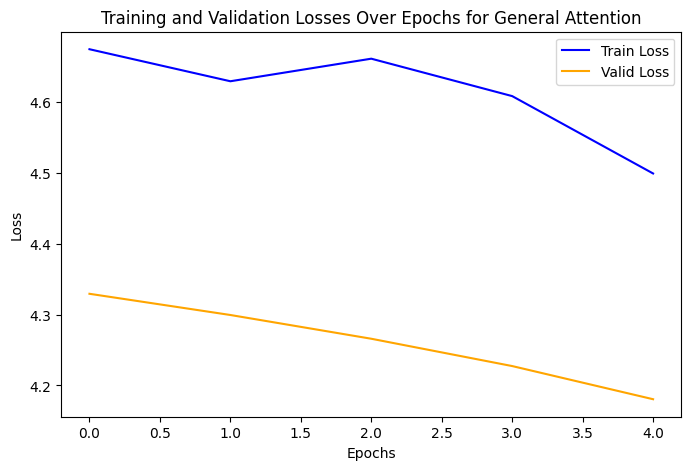

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot training and validation losses
ax.plot(train_losses_general, label='Train Loss', color='blue')
ax.plot(valid_losses_general, label='Valid Loss', color='orange')

# Add title, labels, and legend
plt.title('Training and Validation Losses Over Epochs for General Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Path to the saved model file
save_path = 'general_Seq2SeqTransformer.pt'

# Load the model parameters and state
params, state = torch.load(save_path)

# Initialize the Seq2SeqTransformer model using the loaded parameters and move it to the specified device
model = Seq2SeqTransformer(**params, device=device).to(device)

# Load the model state
model.load_state_dict(state)

# Evaluate the model on the test data and calculate the test loss
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

# Print the test loss and test perplexity
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

#### Training with Multiplicative Model

In [82]:
## Working with multiplicative attention
attn_variant = "multiplicative"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attn_variant,
              device)

model_multiplicative = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_multiplicative.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model_multiplicative.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model_multiplicative = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_multiplicative.apply(initialize_weights)

best_valid_loss = float('inf')
train_losses_multiplicative = []
valid_losses_multiplicative = []
print(f'\n##### {attn_variant} #####')

total_epoch_time = 0  # Variable to store the total time taken for all epochs

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model_multiplicative, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_multiplicative, valid_loader, criterion, val_loader_length)

    # for plotting
    train_losses_multiplicative.append(train_loss)
    valid_losses_multiplicative.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses_multiplicative
final_train_loss = train_losses_multiplicative[-1]
final_valid_loss = valid_losses_multiplicative[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

# Calculate time taken for the traning
average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))

print(f'Final Training Loss: {final_train_loss:.3f} | Final Validation Loss: {final_valid_loss:.3f} | Final Train PPL {final_train_ppl:.3f} | Final Valid PPL {final_valid_ppl:.3f} | Average Time per epoch {average_time_per_epoch} | Overall time {overall_average_time}')



##### multiplicative #####
Epoch: 01 | Time: 11m 29s
	Train Loss: 8.900 | Train PPL: 7333.342
	Val. Loss: 7.834 | Val. PPL: 2526.030
Final Training Loss: 8.900 | Final Validation Loss: 7.834 | Final Train PPL 7333.342 | Final Valid PPL 2526.030 | Average Time per epoch (689.8926768302917,) | Overall time 0.22076565658569336


In [ ]:
# Iterate through different attention mechanisms
for attn_variant in ['general', 'multiplicative', 'additive']:
    
    # Initialize the encoder with the given attention variant
    enc = Encoder( input_dim, hid_dim, enc_layers, enc_heads,enc_pf_dim, enc_dropout,attn_variant,device)
    
     # Initialize the decoder with the same attention variant
    dec = Decoder(output_dim,hid_dim,dec_layers,dec_heads,dec_pf_dim,dec_dropout,attn_variant,device)

    # Create the Seq2Seq Transformer model and move it to the device (CPU/GPU)
    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)     # Initialize model weights

    # Define the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)  # Ignore padding tokens in loss calculation

    save_path = f'{attn_variant}_{model.__class__.__name__}.pt'  # Path to save the best model

    best_valid_loss = float('inf')   # Track the best validation loss
    train_losses = []    # Store training loss values for analysis
    valid_losses = []   # Store validation loss values

    print(f'\n********* {attn_variant} *********')      # Indicate which attention variant is being trained
   
    # Training loop
    for epoch in range(num_epochs):
        start_time = time.time()

        # Train the model for one epoch
        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
        
        # Store loss values for plotting later
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
       
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
         # Save the model only if validation loss improves
        if valid_loss <= best_valid_loss:
            best_valid_loss = valid_loss
            torch.save([model.params, model.state_dict()], save_path) # Save only the best model
       
        # Print epoch results
        print(f'Epoch: {epoch+1:02} | Time Taken: {epoch_mins}min {epoch_secs}sec')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

     # Free up GPU memory by deleting models
    del enc, dec, model
    gc.collect()
    torch.cuda.empty_cache()


********* general *********
Epoch: 01 | Time Taken: 13min 37sec
	Train Loss: 9.001 | Train PPL: 8108.875
	 Val. Loss: 7.822 |  Val. PPL: 2494.049
Epoch: 02 | Time Taken: 12min 20sec
	Train Loss: 7.273 | Train PPL: 1441.128
	 Val. Loss: 6.381 |  Val. PPL: 590.756
Epoch: 03 | Time Taken: 14min 19sec
	Train Loss: 5.797 | Train PPL: 329.272
	 Val. Loss: 4.889 |  Val. PPL: 132.865
Epoch: 04 | Time Taken: 11min 30sec
	Train Loss: 4.298 | Train PPL:  73.545
	 Val. Loss: 3.379 |  Val. PPL:  29.343
Epoch: 05 | Time Taken: 11min 14sec
	Train Loss: 2.817 | Train PPL:  16.721
	 Val. Loss: 1.943 |  Val. PPL:   6.981

********* multiplicative *********
Epoch: 01 | Time Taken: 11min 10sec
	Train Loss: 8.854 | Train PPL: 7001.504
	 Val. Loss: 7.737 |  Val. PPL: 2291.252
Epoch: 02 | Time Taken: 11min 12sec
	Train Loss: 7.180 | Train PPL: 1312.915
	 Val. Loss: 6.293 |  Val. PPL: 541.031
Epoch: 03 | Time Taken: 11min 14sec
	Train Loss: 5.694 | Train PPL: 297.057
	 Val. Loss: 4.800 |  Val. PPL: 121.461
E

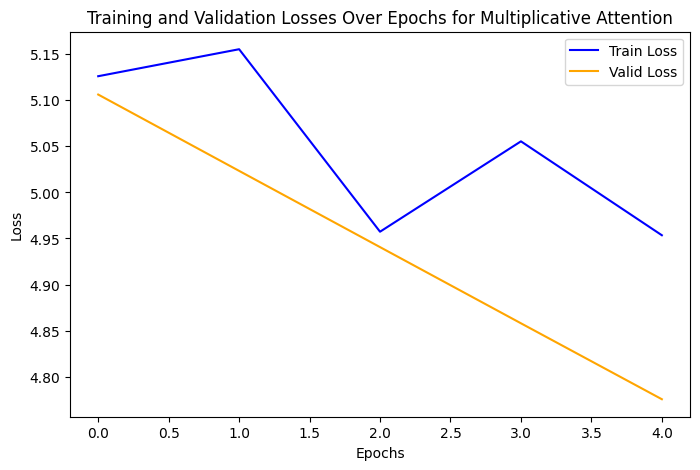

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot training and validation losses
ax.plot(train_losses_multiplicative, label='Train Loss', color='blue')
ax.plot(valid_losses_multiplicative, label='Valid Loss', color='orange')

# Add title, labels, and legend
plt.title('Training and Validation Losses Over Epochs for Multiplicative Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [84]:
save_path = 'multiplicative_Seq2SeqTransformer.pt'
params, state = torch.load(save_path)
model = Seq2SeqTransformer(**params, device=device).to(device)

model.load_state_dict(state)
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.867 | Test PPL:   6.468 |


#### Training with Additive Model

In [89]:
# Working with additive attention
attn_variant = "additive"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

    # Training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

best_valid_loss = float('inf')
train_losses = []
valid_losses = []

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_losses = []
valid_losses = []
print(f'\n##### {attn_variant} #####')

total_epoch_time = 0  # Variable to store the total time taken for all epochs

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses
final_train_loss = train_losses[-1]
final_valid_loss = valid_losses[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

# Calculate time taken for the traning
average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))

print(f'Final Training Loss: {final_train_loss:.3f} | Final Validation Loss: {final_valid_loss:.3f} | Final Train PPL {final_train_ppl:.3f} | Final Valid PPL {final_valid_ppl:.3f} | Average Time per epoch {average_time_per_epoch} | Overall time {overall_average_time}')


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [88]:
save_path = 'additive_Seq2SeqTransformer.pt'
params, state = torch.load(save_path)

model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


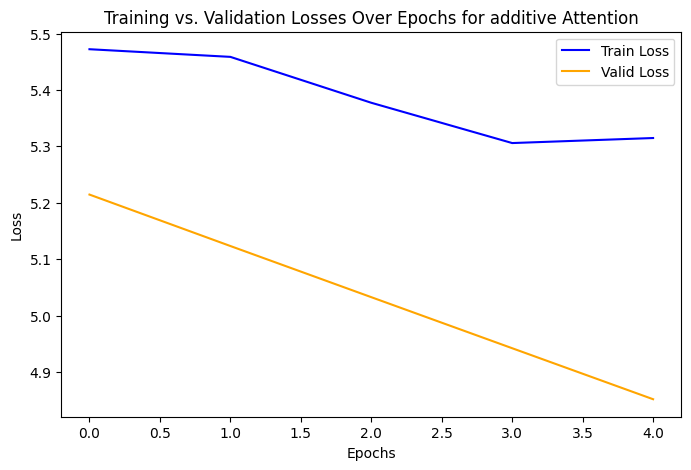

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)


ax.plot(train_losses, label='Train Loss', color='blue')
ax.plot(valid_losses, label='Valid Loss', color='orange')


plt.title('Training vs. Validation Losses Over Epochs for additive Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
output_additive = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_additive.append(token_str)


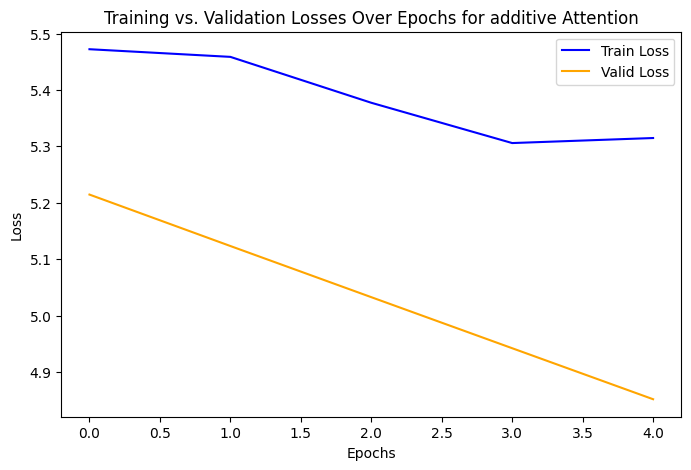

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)


ax.plot(train_losses, label='Train Loss', color='blue')
ax.plot(valid_losses, label='Valid Loss', color='orange')


plt.title('Training vs. Validation Losses Over Epochs for additive Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Attention Maps

In [ ]:
def display_attention(sentence, translation, attention, title):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.set_title(title)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

C:\Users\Mir Ali\AppData\Local\Temp\ipykernel_24428\1425520409.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\Mir Ali\AppData\Local\Temp\ipykernel_24428\1425520409.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)


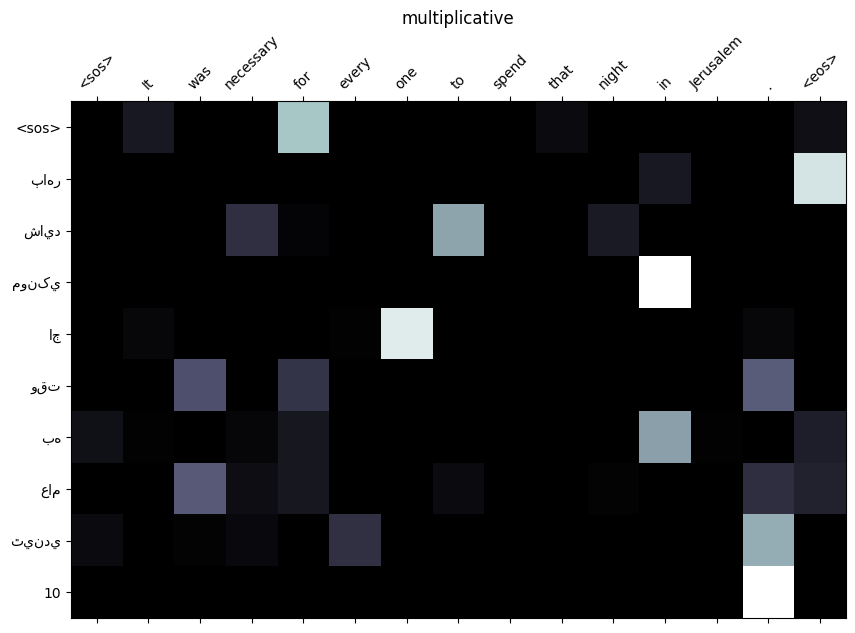

In [ ]:
display_attention(src_tokens, trg_tokens, attention_multiplicative, "multiplicative")

C:\Users\Mir Ali\AppData\Local\Temp\ipykernel_24428\1425520409.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\Mir Ali\AppData\Local\Temp\ipykernel_24428\1425520409.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)


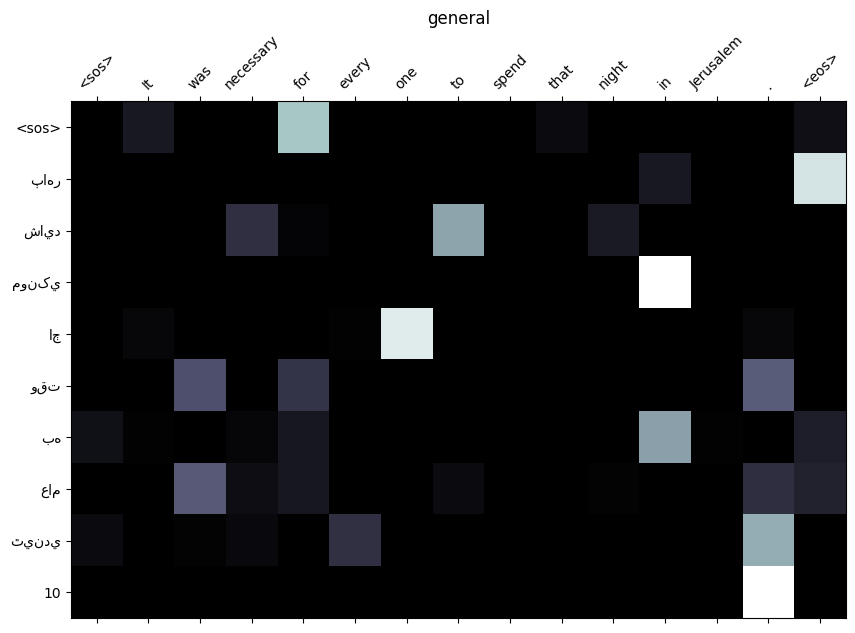

In [ ]:
display_attention(src_tokens, trg_tokens, attention_general, "general")

C:\Users\Mir Ali\AppData\Local\Temp\ipykernel_24428\1425520409.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\Mir Ali\AppData\Local\Temp\ipykernel_24428\1425520409.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)


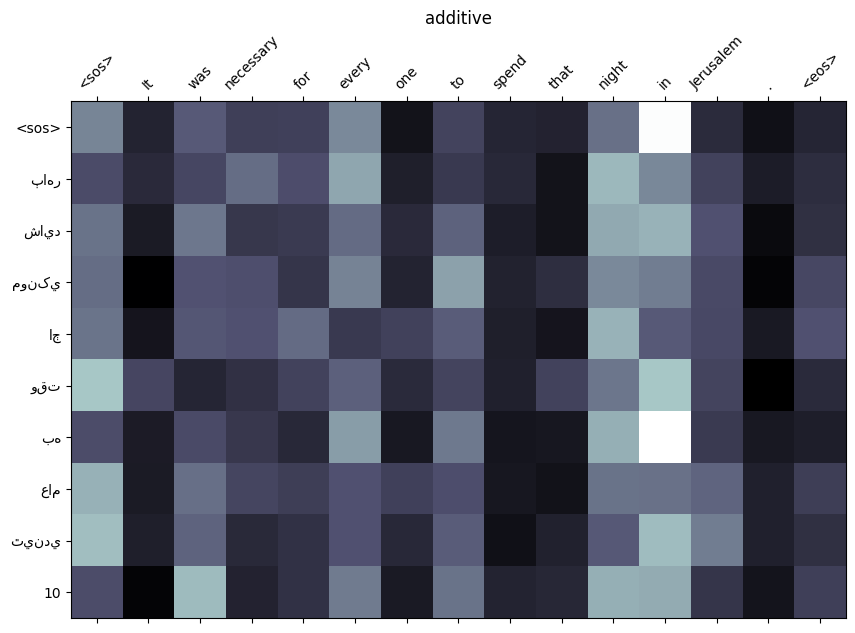

In [ ]:
display_attention(src_tokens, trg_tokens, attention_additive, "additive")